Для первой задачи мы используем данные [Jester Online Joke Recommender System](https://goldberg.berkeley.edu/jester-data/)

**Описание данных**

Файл `train_joke_df.csv` содержит:
- UID - id пользователей
- JID - id шуток, которые 
- Ratin - рейтинг шутки, который проставил пользователь 


Рейтинг имеет значение от -10.00 до 10.00. Могут встречаться значения 99.00, но это обозначает Null (нет рейтинга от пользователя).

Метрика для оценки [RMSE](https://www.codecamp.ru/blog/how-to-interpret-rmse/)

Минимальный RMSE: `4.2238`



In [34]:
#!pip install "scikit-surprise==1.1.3"

In [35]:
#!pip install "xlrd==2.0.1"

### Import

In [36]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts
from surprise.model_selection import KFold

import seaborn as sns
from surprise import SVD
np.random.seed(42)

### Базовые функции для скоринга и получения рекомендаций

In [37]:
def get_num_user_ratings(uid):
    """ возвращает кол-во рейтингов у пользователя 
    args: 
      uid: id пользователей
    returns: 
      кол-во объектов, которые оценил пользователь
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # пользователя не было во время обучения (новый, отправить на стартовые рекомендации)
        return 0
    
def get_num_item_ratings(iid):
    """ возвращает кол-во пользователей, которые оценили выбранный элемент 
    args:
      iid: строка с элементов рекомендации
    returns:
      кол-во пользователей, которые дали оценки по элементу
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
# На основе Surprise FAQ построим рекомендации Топ-N
def get_top_n(predictions, n=5):
    """Определят Топ-N рекомендаций

    Args:
        predictions(list of Prediction objects): Списко рекомендаций, из алгоритма Surprise
        n(int): Кол-во топ рекомендаций

    Returns:
        Словарь пользователь - список рекомендакиций для пользователей
        [(raw item id, rating estimation), ...]
    """

    # Предикт для каждого пользователя
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Сортировка предикта (по пользователям)
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n    

### Загрузка и обработка данных

In [38]:
df = pd.read_csv(r'..\data\recsys-in-practice\train_joke_df.csv')

df.head(5)

,UID,JID,Rating
0,18029,6,-1.26
1,3298,64,-4.17
2,3366,58,0.92
3,12735,92,3.69
4,11365,38,-6.60


In [39]:
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

In [40]:
df_group = df.groupby('UID').agg({'Rating':['min', 'max']}).rename(
    columns={('Rating', 'min'):'Rating_min', ('Rating', 'max'):'Rating_max'})
df_group

Rating      
         min   max
UID               
1      -9.85  9.13
2      -9.66  9.22
3      -7.86  9.37
4      -8.30  8.35
5      -9.66  8.93
...      ...   ...
24979  -9.95  9.27
24980  -9.17  9.22
24981  -7.86  7.38
24982  -9.71  8.30
24983  -9.32  8.98

[24983 rows x 2 columns]

In [41]:
df_group[df_group[('Rating', 'max')] < -5]

Rating      
         min   max
UID               
2156   -8.40 -5.58
3655   -9.61 -5.97
4112   -9.90 -9.32
8710   -9.76 -9.32
9360   -9.76 -9.17
10644  -9.95 -9.66
16122  -9.76 -8.25
17446  -9.51 -9.13
19057  -9.95 -6.17
21141  -8.88 -6.07
21907  -9.95 -9.51
22406  -8.20 -5.34
23459  -9.95 -7.04
23781  -9.95 -7.62
23959  -8.11 -5.53

In [49]:
df_group[df_group[('Rating', 'min')] > 5]

Rating      
         min   max
UID               
1492    5.83  9.37
1988    8.79  9.32
4115    6.12  9.37
6562    6.26  9.32
6703    7.52  8.64
9767    5.97  7.91
10143   7.18  9.13
10295   6.60  8.69
10588   5.68  8.69
12700   8.06  9.08
13990   6.99  9.08
14182   8.30  9.27
18025   6.26  9.22
18857   5.10  8.50
20405   8.40  9.37
20570   7.52  9.32
21636   7.72  9.13
22344   6.89  8.83
22379   5.39  8.45
22711   8.64  9.37
23468   6.12  9.37

In [53]:
df.loc[df['UID'] == 10143]

,UID,JID,Rating
586664,10143,1,4.307692
586665,10143,2,3.984615
586666,10143,3,4.379487
586667,10143,4,4.579487
586668,10143,5,4.630769
...,...,...,...
586742,10143,96,4.082051
586743,10143,97,4.430769
586744,10143,98,4.230769
586745,10143,99,3.958974


In [43]:
df_group.columns

MultiIndex([('Rating', 'min'),
            ('Rating', 'max')],
           )

In [44]:
train_joke_df = df.merge(df_group, how='inner', left_on='UID',  right_index=True)

train_joke_df['Rating_norm'] = train_joke_df['Rating'] / (train_joke_df[('Rating', 'max')] - train_joke_df[('Rating', 'min')])
train_joke_df

C:\Temp\ipykernel_3160\2154885804.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  train_joke_df = df.merge(df_group, how='inner', left_on='UID',  right_index=True)


,UID,JID,Rating,"(Rating, min)","(Rating, max)",Rating_norm
0,1,1,-7.82,-9.85,9.13,-0.412013
1,1,2,8.79,-9.85,9.13,0.463119
2,1,3,-9.66,-9.85,9.13,-0.508957
3,1,4,-8.16,-9.85,9.13,-0.429926
4,1,5,-7.52,-9.85,9.13,-0.396207
...,...,...,...,...,...,...
1448359,24983,67,6.21,-9.32,8.98,0.339344
1448360,24983,68,7.48,-9.32,8.98,0.408743
1448361,24983,69,5.15,-9.32,8.98,0.281421
1448362,24983,71,6.26,-9.32,8.98,0.342077


In [45]:
train_joke_df = train_joke_df.merge(df_group, how='inner', left_on='UID',  right_index=True)

df['Rating'] = train_joke_df['Rating'] / (train_joke_df[('Rating', 'max')] - train_joke_df[('Rating', 'min')])
df

C:\Temp\ipykernel_3160\1513574699.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  train_joke_df = train_joke_df.merge(df_group, how='inner', left_on='UID',  right_index=True)


,UID,JID,Rating
0,1,1,-0.412013
1,1,2,0.463119
2,1,3,-0.508957
3,1,4,-0.429926
4,1,5,-0.396207
...,...,...,...
1448359,24983,67,0.339344
1448360,24983,68,0.408743
1448361,24983,69,0.281421
1448362,24983,71,0.342077


In [46]:
# создадим на основе набора данных
# поднабор, который требуется для библиотеки Surprise

# указываем минимальный и максимальный рейтинги
reader = Reader(rating_scale=(-1, 1))

# передаём набор, указывая последовательность колонок: user (raw) ids, item (raw) ids, ratings
# для Surprise - это обязательно
data = Dataset.load_from_df(df[['UID', 'JID', 'Rating']], reader)

In [47]:
trainset_data = data.build_full_trainset()

# сделаем разделение на обучающую и тестовую выборку
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### Обучение модели

In [43]:

param_grid = {"n_epochs": [10, 20, 50, 100, 200], "n_factors": [32, 64, 100, 128, 256, 512, 1024],'random_state':[0]}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=2,)
gs.fit(data)
     
# результат
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

4.173454475586135
{'n_epochs': 100, 'n_factors': 512, 'random_state': 0}


In [9]:
# обучим с лучшими параметрами
#algo = SVD(random_state=0)
#algo.fit(trainset)

# получим предикт и посмотрим метрику
#predictions = algo.test(testset)
#accuracy.rmse(predictions)

#RMSE: 4.1685

#4.168486060306104

RMSE: 4.1685


4.168486060306104

In [48]:
# обучим с лучшими параметрами
algo = SVD(random_state=0, n_epochs=100, n_factors= 512)
algo.fit(trainset)

# получим предикт и посмотрим метрику
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: inf


inf

### Тестирование и результаты

In [10]:
# получаем предикт
uid = 1  # id пользователя 
iid = 1  # iв шутки

# получим предик на основе обученных данных
# -7.82 - это фактический рейтинг, но посмотрим, какой ответ будет в предикте
pred = algo.predict(uid, iid, r_ui=-7.82, verbose=True)

user: 1          item: 1          r_ui = -7.82   est = -7.62   {'was_impossible': False}


In [11]:
uid = 24983  # id пользователя 
iid = 62     # iв шутки

pred = algo.predict(uid, iid, r_ui=-0.29, verbose=True)

user: 24983      item: 62         r_ui = -0.29   est = -0.06   {'was_impossible': False}


### Обзор рекомендаций

In [12]:
# построим таблицу для обзора набора рекомендаций
# посмотрим, какие элементы и в каком кол-ве рекомендуем
trainset = algo.trainset

predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

predictions_df['№ кол-во пользовательских рейтингов'] = predictions_df.uid.apply(get_num_user_ratings)
predictions_df['№ кол-во рейтингов элементов'] = predictions_df.iid.apply(get_num_item_ratings)
predictions_df['error'] = abs(predictions_df.est - predictions_df.rui)

best_predictions = predictions_df.sort_values(by='error')[:10]
worst_predictions = predictions_df.sort_values(by='error')[-10:]

In [13]:
best_predictions.head(5)

,uid,iid,rui,est,details,№ кол-во пользовательских рейтингов,№ кол-во рейтингов элементов,error
12960,13127,11,5.39,5.389997,{'was_impossible': False},60,13975,0.000003
260297,18613,62,-7.18,-7.180020,{'was_impossible': False},52,16014,0.000020
286194,12206,34,0.97,0.970024,{'was_impossible': False},46,13726,0.000024
56293,7394,80,1.21,1.209962,{'was_impossible': False},32,5807,0.000038
50179,21244,20,-3.06,-3.060059,{'was_impossible': False},37,15957,0.000059


In [14]:
# Предикт для всех, кого нет в выборке для обучения
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions)

# Сделаем вывод рекомендаций
a=0
for uid, user_ratings in top_n.items():
    a+=1
    print(uid, [iid for (iid, _) in user_ratings])
    
    if a==10:
        break

19208 [81, 54, 45, 65, 89]
8671 [8, 21, 32, 83, 18]
6037 [76, 27, 96, 69, 72]
3233 [50, 36, 31, 48, 27]
3449 [51, 83, 100, 80, 6]
10032 [35, 32, 6, 69, 10]
5774 [89, 29, 66, 93, 97]
23392 [53, 62, 35, 11, 29]
3039 [89, 53, 62, 90, 31]
17395 [80, 27, 73, 11, 85]


### Для отправки на тестирование

In [36]:
# обучим с лучшими параметрами
#algo = SVD(random_state=0)
#algo.fit(trainset_data)

# получим предикт и посмотрим метрику
#predictions = algo.test(trainset_data.build_testset())
#accuracy.rmse(predictions)

#RMSE: 0.5627

#0.5626765215970747

RMSE: 0.5627


0.5626765215970747

In [47]:
# обучим с лучшими параметрами
algo = SVD(random_state=0, n_epochs=100, n_factors= 512)
algo.fit(trainset_data)

# получим предикт и посмотрим метрику
predictions = algo.test(trainset_data.build_testset())
accuracy.rmse(predictions)

RMSE: 0.2524


0.25238153948056485

In [45]:
test = pd.read_csv(r'data\recsys-in-practice\test_joke_df_nofactrating.csv', index_col=0)
test.head(5)

,UID,JID
InteractionID,,
0,11228,39
1,21724,85
2,16782,56
3,12105,42
4,14427,2


In [49]:
test['Rating'] = test[['UID', 'JID']].apply(lambda x: algo.predict(x[0], x[1], verbose=False).est,
                                                      axis = 1)
                                                      


In [46]:
# вид набора данных, который должен быть отправлен для тестирования
test['Rating'].to_frame().head(5)

KeyError: 'Rating'

In [51]:
# формирование файла для отправки в Kaggle
test['Rating'].to_frame().to_csv('baseline_svd_tuning_best_4.02408.csv')

C:\ProgramData\Anaconda3\envs\torchvision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rating', ylabel='Density'>

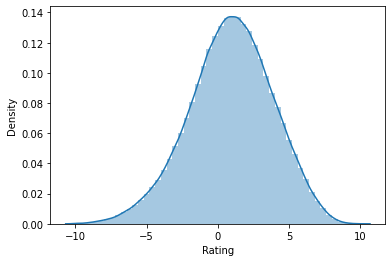

In [54]:
sns.distplot(test['Rating'])

In [49]:
solution = pd.read_csv('baseline_svd_tuning_best_4.02408.csv')

0

In [32]:
def correct(x):
    x2 = round(np.abs(x))
    r = 0
    if x2 == 0: r = 1
    if x2 == 1: r = 1
    if x2 == 2: r = 1
    elif x2 == 3: r = 0.9
    elif x2 == 4: r = 0.8
    elif x2 == 5: r = 0.7
    elif x2 == 6: r = 0.6
    elif x2 == 7: r = 0.5
    elif x2 == 8: r = 0.4
    elif x2 == 9: r = 0.3
    return x + r * np.sign(x)

In [50]:
test['Rating'] = solution['Rating'].apply(correct)
test

,UID,JID,Rating
InteractionID,,,
0,11228,39,3.942851
1,21724,85,-7.539993
2,16782,56,-1.331728
3,12105,42,7.296138
4,14427,2,6.379301
...,...,...,...
362086,3085,66,-1.540293
362087,13765,31,3.404859
362088,10341,29,5.552438


In [40]:
test['Rating'].to_frame().head(5)

,Rating
0,3.942851
1,-7.539993
2,-1.331728
3,7.296138
4,6.379301


In [51]:
test['Rating'].to_frame().to_csv('solution.csv')

C:\ProgramData\Anaconda3\envs\torchvision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\torchvision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\torchvision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

<AxesSubplot:xlabel='Rating2', ylabel='Density'>

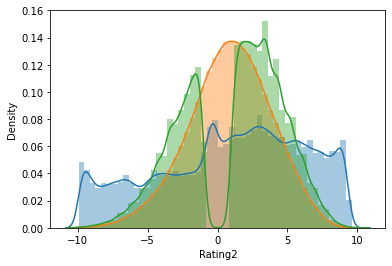

In [35]:

sns.distplot(df['Rating'])
sns.distplot(solution['Rating'])
sns.distplot(solution['Rating2'])

In [19]:
algo.predict(11228, 39, verbose=False)

Prediction(uid=11228, iid=39, r_ui=None, est=0.566071356070457, details={'was_impossible': False})

In [20]:
algo.estimate(u=11228, i=39)

2.113208179753389

In [21]:
algo.bi[:10], algo.bu[:10]

(array([ 0.23980525, -1.07617991,  1.68509211,  0.50801095,  0.78883604,
         1.14263824, -1.94467614, -1.58824921,  0.42888092,  2.01004269]),
 array([-0.24532051, -1.82550659, -0.42334738,  0.13713807, -0.74416467,
         0.06029318, -0.0880148 ,  0.43817758, -0.28725813,  0.25871954]))

In [22]:
algo.pu.shape, algo.qi.shape

((24983, 100), (100, 100))

In [23]:
algo.pu[:10, :10]

array([[-0.2230048 ,  0.66622936,  1.25421384,  1.02214058,  0.08426286,
        -0.4706857 ,  0.13303415, -0.13978567,  0.66577301, -0.62213642],
       [ 1.27324873, -0.4966852 ,  0.13162631,  0.37454828, -0.20073416,
         0.08991341,  0.4608412 , -0.75800289, -0.23261966,  0.27000617],
       [ 0.48164097,  0.484965  ,  0.12173885,  0.57913229, -0.40977931,
        -0.11169338, -0.16766128,  0.06176241, -0.23547473,  0.32488724],
       [ 0.25689661,  0.10174026,  0.07843536,  0.12893532,  0.96274699,
         0.11047802, -0.22591056,  0.4754805 ,  0.06011001, -0.04930576],
       [ 0.09713072, -0.03928024,  0.28553516,  0.25343835, -1.43522594,
        -0.38398627, -0.23012171,  0.53215129, -0.1017679 , -0.17018811],
       [ 0.10640106, -0.0131822 ,  0.06329545,  0.00796486, -0.08144455,
         0.21259789, -0.29223471, -0.08064008, -0.13191688, -0.11658004],
       [-0.54099436,  0.35714124,  0.05025721,  0.36910992,  0.59641854,
        -0.00763266, -0.28486988, -0.13189713

In [24]:
algo.qi[:10, :10]

array([[-0.94479931, -0.09589097,  0.39960378,  0.13403635,  0.15120603,
         1.23239755, -0.55770298,  0.6085744 , -0.20160982, -0.37408129],
       [-0.51499176,  0.71494143, -0.51554793,  0.51640089, -1.4611089 ,
         0.07642739, -0.59257062, -0.77258054,  1.80403563,  0.52207699],
       [-0.52273664, -0.33083418,  0.23276635,  0.43794969,  0.542022  ,
         0.24844269, -0.84266999,  0.75165127, -0.34747414,  1.06975379],
       [-1.49546426,  0.74111805,  0.12275335, -0.25320917, -0.09648191,
        -0.71230206, -0.32988633,  1.26577732, -0.08619805, -0.04458504],
       [-1.10700511, -0.45302107,  0.3930645 ,  1.35997668,  0.41374235,
         0.06221189,  0.62863293,  0.35774988, -0.9625532 , -0.89730624],
       [-0.57042116, -0.23093569, -0.41217521, -0.26014454,  0.32194116,
        -0.16090198, -0.26132014,  1.55420494,  0.9566338 , -0.40168469],
       [-0.02669707, -1.48191085, -0.49140528,  0.8156364 , -0.42658018,
        -0.26524194, -0.84239376, -0.07292947

In [25]:
#r_ui = q_i.T * p_u

In [26]:
joke_df = pd.DataFrame(algo.qi, index=np.arange(1, 101), columns=[f'joke_feature_{i}' for i in np.arange(1, 101)])
joke_df

,joke_feature_1,joke_feature_2,joke_feature_3,joke_feature_4,joke_feature_5,joke_feature_6,joke_feature_7,joke_feature_8,joke_feature_9,joke_feature_10,...,joke_feature_91,joke_feature_92,joke_feature_93,joke_feature_94,joke_feature_95,joke_feature_96,joke_feature_97,joke_feature_98,joke_feature_99,joke_feature_100
1,-0.944799,-0.095891,0.399604,0.134036,0.151206,1.232398,-0.557703,0.608574,-0.201610,-0.374081,...,0.808543,0.400790,0.293808,-1.226068,-0.792814,-0.135820,-0.067093,0.544055,-1.366587,1.282327
2,-0.514992,0.714941,-0.515548,0.516401,-1.461109,0.076427,-0.592571,-0.772581,1.804036,0.522077,...,-0.750966,0.599008,-1.045557,1.320952,0.208481,-0.024767,-1.103751,-1.210373,-0.699545,0.836162
3,-0.522737,-0.330834,0.232766,0.437950,0.542022,0.248443,-0.842670,0.751651,-0.347474,1.069754,...,0.191672,-1.761498,0.234078,0.654207,-0.987648,0.864421,-0.458653,-1.062999,-0.892883,0.115851
4,-1.495464,0.741118,0.122753,-0.253209,-0.096482,-0.712302,-0.329886,1.265777,-0.086198,-0.044585,...,-0.328019,0.716497,0.501920,1.498041,0.253207,-0.056936,-0.178918,-1.068518,-0.185322,1.359837
5,-1.107005,-0.453021,0.393065,1.359977,0.413742,0.062212,0.628633,0.357750,-0.962553,-0.897306,...,-1.327362,-0.074478,-0.588793,0.221514,0.445524,-0.214525,-0.928945,-0.241340,-0.192628,-0.679226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.990665,-1.189798,0.497185,-0.599485,-0.630965,1.268366,-0.282991,-0.720666,0.493119,0.624883,...,-1.023746,0.436897,0.261328,-0.754994,-0.120220,0.667725,-0.109520,-1.689282,-1.422999,-0.415921
97,-0.808417,0.343505,-0.077580,-0.765374,0.227338,-0.505403,0.096021,-0.066198,-2.237164,0.390609,...,-0.464291,0.065591,0.579791,1.346007,-1.786562,1.210587,-0.155541,0.087278,-1.398342,0.232107
98,-0.068547,-0.154841,-0.456779,0.422735,2.322417,-0.904280,-0.777405,0.338712,-0.057070,-0.510049,...,0.969394,-1.137254,0.428099,0.583627,0.145777,-0.543319,0.484765,-0.340168,-0.336664,-1.039537
99,0.380750,0.730784,1.108697,-0.051725,1.042664,-1.322251,-1.020696,0.751510,-0.410733,-0.600999,...,0.533585,-0.947753,-0.737779,0.299972,0.638687,1.070333,1.172371,-1.122903,-0.314028,0.695253


In [27]:
joke_df.to_csv('joke_df_features_svd_best_4.02408.csv', index=False)

In [28]:
user_df = pd.DataFrame(algo.pu, index=np.arange(1, 24984), columns=[f'user_feature_{i}' for i in np.arange(1, 101)])
user_df

,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,user_feature_9,user_feature_10,...,user_feature_91,user_feature_92,user_feature_93,user_feature_94,user_feature_95,user_feature_96,user_feature_97,user_feature_98,user_feature_99,user_feature_100
1,-0.223005,0.666229,1.254214,1.022141,0.084263,-0.470686,0.133034,-0.139786,0.665773,-0.622136,...,-0.025079,1.470007,0.953811,-0.927780,1.245242,0.395978,-0.860707,-0.600240,0.737459,0.619714
2,1.273249,-0.496685,0.131626,0.374548,-0.200734,0.089913,0.460841,-0.758003,-0.232620,0.270006,...,-0.089958,0.549117,0.205163,-0.413112,0.055504,-0.391050,0.293751,0.471825,0.174198,0.601748
3,0.481641,0.484965,0.121739,0.579132,-0.409779,-0.111693,-0.167661,0.061762,-0.235475,0.324887,...,0.093905,-0.393804,0.495433,-0.211504,-0.108357,0.108905,0.322766,0.301871,-0.052878,0.010351
4,0.256897,0.101740,0.078435,0.128935,0.962747,0.110478,-0.225911,0.475480,0.060110,-0.049306,...,-0.383951,-0.166333,0.260032,-0.149003,0.236467,-0.027811,-0.051346,0.236596,0.412815,-0.312536
5,0.097131,-0.039280,0.285535,0.253438,-1.435226,-0.383986,-0.230122,0.532151,-0.101768,-0.170188,...,0.169757,-0.326543,0.557767,0.003950,-0.712151,-0.779678,-0.769931,-0.088174,-0.266479,0.390875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,0.370652,0.445775,-0.703307,0.524486,-0.084853,-0.184279,0.481619,0.166697,-0.081893,0.128661,...,-0.407998,-0.142099,-0.028747,0.274365,0.319276,0.191534,0.182201,0.020713,-0.218555,0.027675
24980,-0.084768,-0.240659,-0.046023,-0.265900,0.138962,-0.055115,0.318063,0.027792,0.527656,-0.095275,...,0.173306,-0.233048,0.197689,0.346758,-0.293345,-0.137145,0.421463,0.145748,-0.070763,-0.014408
24981,0.108673,-0.168490,-0.060695,-0.387506,-0.197779,-0.135375,0.093088,0.040084,0.434001,0.377280,...,-0.094087,0.463405,-0.250437,-0.323965,-0.272252,-0.377110,-0.498288,0.477951,-0.259032,0.186928
24982,0.252501,-0.183175,-0.117824,0.092423,0.142230,0.164830,0.314396,-0.260483,0.128533,-0.017766,...,0.084426,0.103601,-0.147195,-0.684595,0.364398,-0.067204,0.728748,0.166597,-0.065728,0.291203


In [29]:
user_df.to_csv('user_df_features_svd_best_4.02408.csv', index=False)

In [30]:
df_features = df.merge(user_df, left_on='UID', right_index=True).merge(joke_df, left_on='JID', right_index=True)
df_features

,UID,JID,Rating,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,...,joke_feature_91,joke_feature_92,joke_feature_93,joke_feature_94,joke_feature_95,joke_feature_96,joke_feature_97,joke_feature_98,joke_feature_99,joke_feature_100
0,1,1,-7.82,-0.223005,0.666229,1.254214,1.022141,0.084263,-0.470686,0.133034,...,0.808543,0.400790,0.293808,-1.226068,-0.792814,-0.135820,-0.067093,0.544055,-1.366587,1.282327
62,2,1,4.08,1.273249,-0.496685,0.131626,0.374548,-0.200734,0.089913,0.460841,...,0.808543,0.400790,0.293808,-1.226068,-0.792814,-0.135820,-0.067093,0.544055,-1.366587,1.282327
226,5,1,8.50,0.097131,-0.039280,0.285535,0.253438,-1.435226,-0.383986,-0.230122,...,0.808543,0.400790,0.293808,-1.226068,-0.792814,-0.135820,-0.067093,0.544055,-1.366587,1.282327
578,10,1,3.01,-0.148461,-0.424992,-0.007616,-0.121018,-0.207329,0.413151,-0.114745,...,0.808543,0.400790,0.293808,-1.226068,-0.792814,-0.135820,-0.067093,0.544055,-1.366587,1.282327
643,11,1,-2.91,-0.025786,0.289998,-0.200257,-0.069776,0.516586,-0.073196,0.152180,...,0.808543,0.400790,0.293808,-1.226068,-0.792814,-0.135820,-0.067093,0.544055,-1.366587,1.282327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447088,24959,75,-2.38,-0.451111,-0.185688,-0.251717,0.559206,-0.125845,-0.028946,0.386307,...,0.545959,-0.969739,0.304133,-0.244106,0.024547,0.271086,-1.912713,-0.702924,-1.225949,0.526137
1447277,24963,75,-6.80,0.378362,0.441735,0.463891,-0.434979,0.022707,0.464170,0.263465,...,0.545959,-0.969739,0.304133,-0.244106,0.024547,0.271086,-1.912713,-0.702924,-1.225949,0.526137
1447442,24966,75,2.91,0.029022,0.179793,-0.138766,-0.069460,0.214055,0.078901,0.029813,...,0.545959,-0.969739,0.304133,-0.244106,0.024547,0.271086,-1.912713,-0.702924,-1.225949,0.526137
1447808,24972,75,-3.98,-0.259201,0.166574,0.263745,-0.138429,-0.313510,0.023249,0.145662,...,0.545959,-0.969739,0.304133,-0.244106,0.024547,0.271086,-1.912713,-0.702924,-1.225949,0.526137


In [31]:
df_features.to_csv('df_features_svd_best_4.02408.csv', index=False)

In [32]:
df_test_features = test.merge(user_df, left_on='UID', right_index=True).merge(joke_df, left_on='JID', right_index=True)
df_test_features

,UID,JID,Rating,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,...,joke_feature_91,joke_feature_92,joke_feature_93,joke_feature_94,joke_feature_95,joke_feature_96,joke_feature_97,joke_feature_98,joke_feature_99,joke_feature_100
InteractionID,,,,,,,,,,,,,,,,,,,,,
0,11228,39,0.566071,-0.213628,0.558210,0.016460,-0.056455,-0.762370,-0.159715,-0.144576,...,-0.008013,0.118106,0.933128,0.818367,-0.083939,-0.099699,-0.233409,0.441137,-0.538770,1.170568
14,13992,39,1.398306,0.491802,-0.349127,-0.387217,-0.056967,0.275242,-0.317949,0.577582,...,-0.008013,0.118106,0.933128,0.818367,-0.083939,-0.099699,-0.233409,0.441137,-0.538770,1.170568
230989,13100,39,-1.372803,-0.389665,0.204069,-0.329976,-0.018127,-0.002785,0.122212,-0.491148,...,-0.008013,0.118106,0.933128,0.818367,-0.083939,-0.099699,-0.233409,0.441137,-0.538770,1.170568
226103,11004,39,-7.786615,-0.022825,0.652404,-0.794837,-0.990705,0.355056,-0.049321,0.029653,...,-0.008013,0.118106,0.933128,0.818367,-0.083939,-0.099699,-0.233409,0.441137,-0.538770,1.170568
42319,22191,39,-1.621712,-0.129071,0.138773,0.131375,-0.081165,-0.733929,0.911086,-0.071055,...,-0.008013,0.118106,0.933128,0.818367,-0.083939,-0.099699,-0.233409,0.441137,-0.538770,1.170568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204228,8615,80,-0.261417,0.251412,-0.465081,-0.121258,0.130927,-0.322917,-0.142261,0.113408,...,-0.369874,0.689104,-0.628630,0.293638,-0.242378,0.237712,1.304191,-0.122419,-0.034374,-0.359209
131692,2409,80,-0.135927,-0.913429,-0.061408,0.232931,0.277586,-0.214656,0.023103,0.012471,...,-0.369874,0.689104,-0.628630,0.293638,-0.242378,0.237712,1.304191,-0.122419,-0.034374,-0.359209
134883,2966,80,-3.686331,-0.349282,0.029385,0.075706,0.232646,-0.270829,0.009274,0.178695,...,-0.369874,0.689104,-0.628630,0.293638,-0.242378,0.237712,1.304191,-0.122419,-0.034374,-0.359209


In [33]:
df_test_features.to_csv('df_test_features_svd_best_4.02408.csv')